In [1]:
import numpy as np
import scipy.io.wavfile as wav
import scipy.sparse as scilin
import matplotlib.pyplot as plt
import sklearn.decomposition as skd
import math
import numpy.linalg as la

In [2]:
def spectrogram(signal, ws = 1024, hs = 512):
    # compute Hamming weights
    alpha   = 0.54
    beta    = 1 - alpha
    pi2     = 2.0*math.pi
    c       = pi2/(ws-1)
    w       = alpha - beta * np.cos(c*np.arange(0,ws,1))

    # compute DFT matrix
    p = np.arange(0,ws,1).reshape(ws,1)
    F = np.exp( -(pi2/ws)*np.matmul(p,p.T)*1j )  / np.sqrt(ws)

    # compute resulting local matrix
    D = np.multiply(F,w)

    # Compute number of samples in spectrogram
    (len,c)     = signal.shape
    num_samples = math.floor((len - hs)/(ws - hs))

    # initialize output S
    S = np.zeros((ws,num_samples),dtype=type(F[0,0]))

    # loop through and construct S
    for i in range(0,num_samples):
        S[:ws, i] = np.matmul(D,signal[i*hs:(i*hs+ws),0])

    # return the output spectrogram
    return S[:int(ws/2),:]

In [3]:
def pca(centeredData, numOfComponents):
    [U,s,Vt] = la.svd(centeredData)
    Uk = U[:,:numOfComponents]
    sk = s[:numOfComponents]
    Wp = np.diag(sk**-0.5) @ Uk.T
    return Wp

In [4]:
def ICA(Zp, thresh=50, alpha=1e-5):
    k, n = np.shape(Zp)
    W = np.eye(k)
    y = W @ Zp
    M, N = np.shape(y)
    mag_dW = thresh *100
    i = 0
    while (mag_dW > thresh):
        gradW = ((N*np.eye(k) - 2 * np.tanh(y) @ y.T)) @ W
        newW = W + alpha * gradW
        mag_dW = np.linalg.norm(gradW)
        W = newW
        y = W @ Zp
        if(i%700 == 0):
            print(mag_dW)
        i+=1
    return W

In [5]:
def nmf(X, tol=.001, max_iter=5000, n_components=3):

    # Random initialization of weights
    W = np.random.rand(X.shape[0], n_components)
    H = np.random.rand(n_components, X.shape[1])

    # A very big number for initial error
    oldlim = 1e5

    # A very small number to ensure matrices are strictly positive
    eps = 1e-7
    
    for i in range(max_iter):
      
        # Multiplicative update steps
        H = H * ((W.T.dot(X) + eps) / (W.T.dot(W).dot(H) + eps))
        W = W * ((X.dot(H.T) + eps) / (W.dot(H.dot(H.T)) + eps))

        # Frobenius distance between WH and X
        lim = np.linalg.norm(X-W.dot(H), 'fro')
        if(i%700 == 0):
            print(abs(oldlim - lim))
        # Check for convergence
        if abs(oldlim - lim) < tol:
            break

        oldlim = lim
        
    return W,H

In [6]:
# define the number of features you want
num_features    = 3

# load the sound file and get into proper shape
(freq,signal)   = wav.read('../data/vl1.wav')
N               = signal.shape[0]
signal          = signal.reshape(N,1)

In [7]:
window_size     = 1024
hop_size        = int(window_size/4)
S               = spectrogram(signal,ws=window_size,hs=hop_size)

# find the sqrt of the magnitude of the spectrogram matrix
(r,c)           = S.shape
Sn              = np.abs(S)
Snsq            = np.sqrt(Sn)


In [8]:
# compute mean of spectrogram data
mu_s            = (Sn @ np.ones((c,1))/c)

# subtract mean from data
Sn_d            = Sn - mu_s

In [9]:
Wp = pca(Sn_d,num_features)
Zp = Wp @ Sn_d

In [10]:
Wi = ICA(Zp) @ Zp
Wi_inv = np.linalg.pinv(Wi)

13265.797975572224
219.0524497214441
63.081298078768626


In [11]:
Wnmf, Hnmf = nmf(Sn)

306935.17214157915
0.05992734234314412
0.005459588981466368
0.0016964560491032898


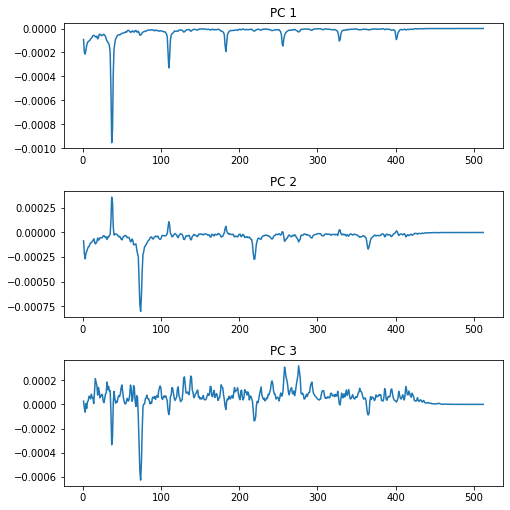

In [12]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot(ind, Wp.T[:, k])
    ax1[k].set_title('PC '+str(k+1))
fig.set_figheight(7)
fig.set_figwidth(7)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

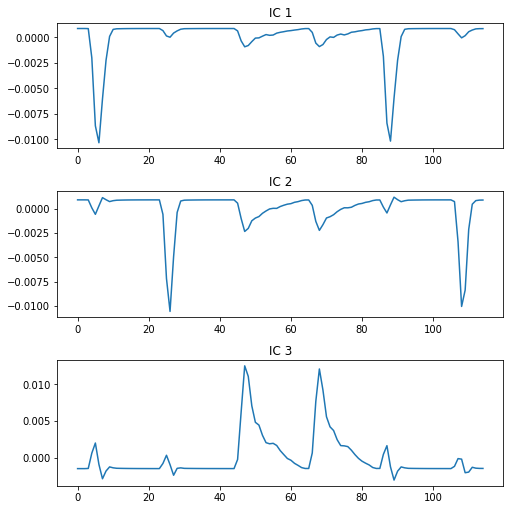

In [13]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( Wi_inv[:, k])
    ax1[k].set_title('IC '+str(k+1))
fig.set_figheight(7)
fig.set_figwidth(7) 
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

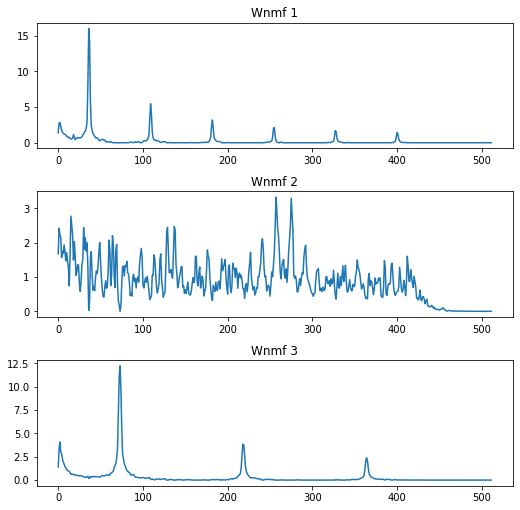

In [14]:
ind = 1 + np.arange(0, int(window_size/2))
fig, ax1 = plt.subplots(nrows = 3, ncols = 1)

for k in range(0,3):
    ax1[k].plot( Wnmf[:, k])
    ax1[k].set_title('Wnmf '+str(k+1))
fig.set_figheight(7)
fig.set_figwidth(7)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [15]:
# load data and set some helper variables
X = np.load("../Data/digits-labels.npz")["d"]
m, n = X.shape # m is number of features and n is number of images
k = 36 # k is the number of pc's we want

print(f"We have {n} images of vectorized length {m}. We are trying to reduce these images to be {k}-dimensional.")

We have 10000 images of vectorized length 784. We are trying to reduce these images to be 36-dimensional.


(36, 784)
(36, 784)


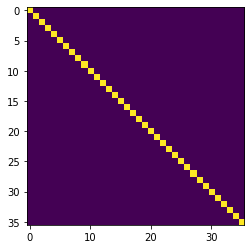

In [16]:
# 1. do pca using svd to get eigen vectors and eigen values

# center data
mu_image = (1/n) * (X @ np.ones((n,1)))
X_zeroed = X - mu_image

# get covariance of X_zeroed
cov_X_zeroed = (1/(n-1)) * (X_zeroed @ X_zeroed.T)

# run PCA on this covariance to get Wp
Wp = pca(cov_X_zeroed, k)
print(np.shape(Wp))
Wp_inv = np.linalg.pinv(Wp)
print(np.shape(Wp))

Zp = Wp@ X_zeroed
plt.imshow(Zp@Zp.T)

In [17]:
# 3. do ica on Zp to get Wi
Wi = ICA(Zp, thresh=50, alpha=1e-5)

13411.520807891244
2519.874575437956
1942.3830019990685
1402.292193252508
1136.2439934813199
883.7847529025178
671.7084744420725
505.64971792563006
425.2449798379876
384.63131238473045
374.8060809221286
367.70777311186146
303.6512624860678
248.2122227946098
231.36926687849146
228.52483707239676
215.0231233082491
188.01029661094566
157.73042975617213
131.00060770712068
109.99836302659256
94.71392244150682
84.26364765584104
77.43290069059168
72.9846316036089
69.86862708194069
67.3217753144246
64.87242826975265
62.29301494914422
59.535583831989996
56.66595681280583
53.80448217198444
51.08017563276299


In [18]:
# 4. Do NMF on non centered data
Wnmf, Hnmf = nmf(X, tol=.1, max_iter=5000, n_components=36)

99291.64996739374
0.31496924896225664


In [19]:
WI = Wi @ Wp
WI_inv = np.linalg.pinv(WI)

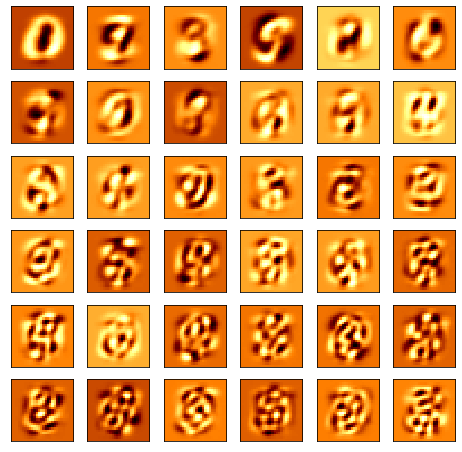

In [20]:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(Wp.T[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)

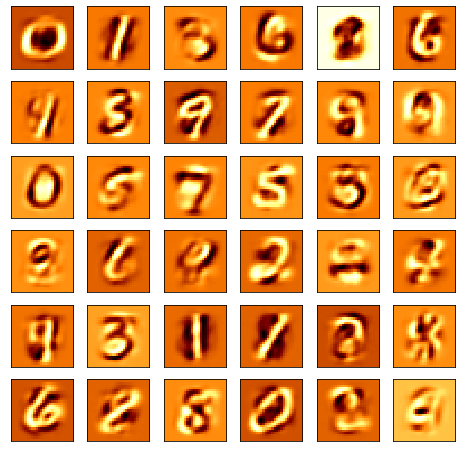

In [21]:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(WI_inv[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)

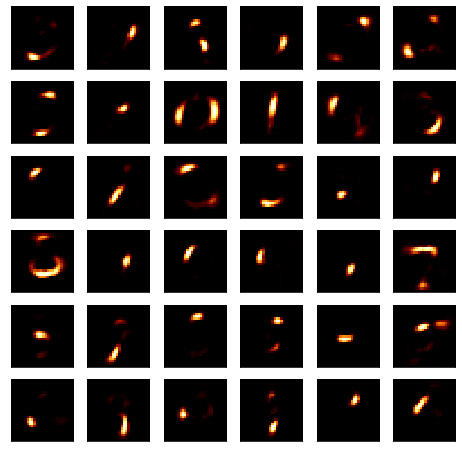

In [22]:
fig, axs = plt.subplots(6, 6)

for i in range(6):
    for j in range(6):
        dataIndex = 6*i+j
        axs[i, j].imshow(np.reshape(Wnmf[:,dataIndex],(28,28),'F'), cmap=plt.cm.afmhot)
counter = 0
for ax in axs.flatten():
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])

    counter += 1
fig.set_figheight(8)
fig.set_figwidth(8)